In [1]:
# Define time steps
TIME_STEPS = 3
EPOCHS = 1
BATCH_SIZE = 16
FEATURES = ['PM10']
# ['AMB_TEMP', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'RAINFALL', 'RH', 'SO2', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'WS_HR', 'Longitude', 'Latitude', 'CH4', 'NMHC', 'THC']
TARGET = 'PM2.5'

output_dir = './Predict_Result'
output_path = './Predict_Result/significant_errors.csv'

# Model Preprocessing

### Import Libraries and Set Seeds
Import necessary libraries and set random seeds to ensure reproducibility.

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from scipy.interpolate import griddata
from matplotlib import rcParams
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Activation, GRU
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, concatenate, Flatten, Cropping2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from scipy.spatial import QhullError

In [4]:
def set_seeds(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)
    tf.keras.utils.set_random_seed(seed_value)
    tf.config.experimental.enable_op_determinism()
set_seeds()

In [5]:
rcParams['font.family'] = 'Times New Roman'
rcParams['axes.unicode_minus'] = False

### Load Data and Data Preprocessing
Load air quality data from multiple CSV files.

In [6]:
filename_1 = './../data_clean/中部空品區_合併/merged_air_quality_data/二林_AllYear_Merged_Dataset.csv'
filename_2 = './../data_clean/中部空品區_合併/merged_air_quality_data/南投_AllYear_Merged_Dataset.csv'
filename_3 = './../data_clean/中部空品區_合併/merged_air_quality_data/埔里_AllYear_Merged_Dataset.csv'
filename_4 = './../data_clean/中部空品區_合併/merged_air_quality_data/大里_AllYear_Merged_Dataset.csv'
filename_5 = './../data_clean/中部空品區_合併/merged_air_quality_data/彰化_AllYear_Merged_Dataset.csv'
filename_6 = './../data_clean/中部空品區_合併/merged_air_quality_data/忠明_AllYear_Merged_Dataset.csv'
filename_7 = './../data_clean/中部空品區_合併/merged_air_quality_data/沙鹿_AllYear_Merged_Dataset.csv'
filename_8 = './../data_clean/中部空品區_合併/merged_air_quality_data/竹山_AllYear_Merged_Dataset.csv'
filename_9 = './../data_clean/中部空品區_合併/merged_air_quality_data/線西_AllYear_Merged_Dataset.csv'
filename_10 = './../data_clean/中部空品區_合併/merged_air_quality_data/西屯_AllYear_Merged_Dataset.csv'
filename_11 = './../data_clean/中部空品區_合併/merged_air_quality_data/豐原_AllYear_Merged_Dataset.csv'

In [7]:
df_1 = pd.read_csv(filename_1)
# df_2 = pd.read_csv(filename_2)
# df_3 = pd.read_csv(filename_3)
df_4 = pd.read_csv(filename_4)
# df_5 = pd.read_csv(filename_5)
# df_6 = pd.read_csv(filename_6)
# df_7 = pd.read_csv(filename_7)
# df_8 = pd.read_csv(filename_8)
# df_9 = pd.read_csv(filename_9)
# df_10 = pd.read_csv(filename_10)
# df_11 = pd.read_csv(filename_11)

In [8]:
station_dfs =   [df_1,  df_4]# , df_5,  df_6,  df_7,  df_9,  df_10,  df_11]
station_names = ['二林']
# ['二林', '大里']# , '彰化', '忠明', '沙鹿', '線西', '西屯', '豐原']


station_predictions = []

### Plot Predictions and History
This function creates a figure with two subplots side by side. The first subplot shows the true vs. predicted PM2.5 values over time, and the second subplot shows the prediction error over time.

In [9]:
def plot_predictions_and_history(y_true_inv_df, y_pred_inv_df, history, station_name):
    # Create a figure with 2 subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot true vs predicted values
    ax[0].plot(y_true_inv_df.index, y_true_inv_df['PM2.5'], label='True PM2.5')
    ax[0].plot(y_pred_inv_df.index, y_pred_inv_df['PM2.5'], label='Predicted PM2.5')
    ax[0].set_title('True vs Predicted PM2.5')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('PM2.5 Concentration')
    ax[0].set_ylim(0, 100)  # Set y-axis limit from 0 to 100
    ax[0].legend()
    
    y_true_inv_df = y_true_inv_df.rename(columns={'PM2.5': 'True_PM2.5'})
    y_pred_inv_df = y_pred_inv_df.rename(columns={'PM2.5': 'Predicted_PM2.5'})
    error_df = y_true_inv_df.join(y_pred_inv_df, how='inner')
    error_df['Absolute_Error'] = abs(error_df['True_PM2.5'] - error_df['Predicted_PM2.5'])
    mean_absolute_error = error_df['Absolute_Error'].mean()
    
    # Plot error
    ax[1].plot(error_df.index, error_df['Absolute_Error'], color='red', label='Prediction Error')
    ax[1].axhline(y=mean_absolute_error, color='blue', linestyle='--', label=f'Mean Absolute Error: {mean_absolute_error:.2f}')

    ax[1].set_title('Prediction Error Over Time')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Error (True - Predicted)')
    ax[1].set_ylim(0, 100)  # Set y-axis limit from 0 to 100
    ax[1].legend()
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
    return error_df

In [10]:
def plot_convergence(training_history):
    # Create a new figure for convergence plotting
    plt.figure(figsize=(14, 6))
    
    # Extract the metrics from the training history
    history_dict = training_history.history
    
    # Plot loss over epochs
    plt.subplot(1, 3, 1)
    plt.plot(history_dict['loss'], label='Loss')
    plt.plot(history_dict.get('val_loss', []), label='Val Loss', linestyle='--')  # Validation Loss
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot MAE over epochs
    plt.subplot(1, 3, 2)
    plt.plot(history_dict.get('mae', history_dict.get('mean_absolute_error', [])), label='MAE')
    plt.plot(history_dict.get('val_mae', []), label='Val MAE', linestyle='--')  # Validation MAE
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE Over Epochs')
    plt.legend()
        
    # Plot RMSE over epochs
    plt.subplot(1, 3, 3)
    plt.plot(history_dict.get('rmse', history_dict.get('root_mean_squared_error', [])), label='RMSE')
    plt.plot(history_dict.get('val_rmse', []), label='Val RMSE', linestyle='--')  # Validation RMSE
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('RMSE Over Epochs')
    plt.legend()


    plt.tight_layout()
    plt.show()

In [11]:
def plot_error_histogram(y_true, y_pred, title='Error Distribution'):
    # Calculate errors
    errors = y_true - y_pred
    
    # Plot error histogram
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30, edgecolor='black')
    plt.title(title)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
    plt.legend()
    
    # Calculate and print some error statistics
    mean_error = np.mean(errors)
    median_error = np.median(errors)
    std_error = np.std(errors)

    print(f"Mean Error: {mean_error:.2f}, Median Error: {median_error:.2f}, Standard Deviation of Error: {std_error:.2f}")
    plt.show()

    # Plot scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
    plt.xlabel('Actual PM2.5')
    plt.ylabel('Predicted PM2.5')
    plt.title('Predicted vs Actual PM2.5')
    plt.show()

# Temporal Data Process

### Define and Train LSTM Model
Create an LSTM model, train it, and make predictions.

In [12]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [13]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
def train_lstm_model(X_train, y_train, X_test, y_test, epochs=5, batch_size=32):
    # Define LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(GRU(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.0001)

    # 編譯模型時同時指定 MAE 和 RMSE 作為 metrics
    model.compile(optimizer=optimizer,
                  loss=Huber(),
                  metrics=[rmse, 'mae'])
    
    early_stopping = EarlyStopping(monitor='loss',  
                           patience=3,
                           restore_best_weights=True)
    
    # 訓練模型
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size, 
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])
    
    # Predict using the LSTM model
    predictions = model.predict(X_test)

    return model, predictions, history

### Evaluate Model
Evaluate model performance, plot prediction results, and error distribution.

In [14]:
def evaluate_model(model, X_test, y_test, scaler_target, history, test_index):
    # Evaluate the model on test data
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    
    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse scaling to get actual values
    y_test_inv = scaler_target.inverse_transform(y_test)
    y_pred_inv = scaler_target.inverse_transform(y_pred)
    
    # Convert predictions and test data to DataFrames with time index
    y_test_inv_df = pd.DataFrame(y_test_inv, index=test_index, columns=['PM2.5'])
    y_pred_inv_df = pd.DataFrame(y_pred_inv, index=test_index[:len(y_pred_inv)], columns=['PM2.5'])

    plot_error_histogram(y_test_inv_df['PM2.5'], y_pred_inv_df['PM2.5'], 'PM2.5 Prediction Error Distribution')    
    return y_pred_inv_df, y_test_inv_df

In [15]:
def process_and_predict(station_df, features, target, time_steps, station_name):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)    
        
    station_df = station_df.copy()
    station_df = station_df.dropna()
    station_df['時間'] = pd.to_datetime(station_df['時間'])
    station_df.set_index('時間', inplace=True)

    # Extract latitude and longitude (assuming they are the same for all rows)
    latitude, longitude = station_df['Latitude'].iloc[0], station_df['Longitude'].iloc[0]
    
    # Check which features are present in the DataFrame
    available_features = [col for col in features if col in station_df.columns and station_df[col].notnull().all()]
    
    # Split the data into training set (2019-01-01 ~ 2022-12-31) and test set (2023-01-01 ~)
    train_data = station_df[(station_df.index >= '2019-01-01 00:00:00') & (station_df.index < '2023-01-01 00:00:00')]
    test_data = station_df[station_df.index > '2023-01-01 00:00:00']
    
    # # Use PM10 to predict PM2.5 via a linear regression model
    # regression_model = LinearRegression()
    # regression_model.fit(train_data[available_features], train_data[[target]])

    # # Predict PM2.5 from PM10 for train and test sets
    # train_data['PM2.5_reg_pred'] = regression_model.predict(train_data[available_features])
    # test_data['PM2.5_reg_pred'] = regression_model.predict(test_data[available_features])

    # # Residuals as new target for the LSTM model
    # train_data['PM2.5_residual'] = train_data[target] - train_data['PM2.5_reg_pred']
    # test_data['PM2.5_residual'] = test_data[target] - test_data['PM2.5_reg_pred']

    
    scaler_features, scaler_target = StandardScaler(), StandardScaler()
    train_scaled_features = scaler_features.fit_transform(train_data[available_features])
    test_scaled_features = scaler_features.transform(test_data[available_features])
    train_scaled_target = scaler_target.fit_transform(train_data[[target]])
    test_scaled_target = scaler_target.transform(test_data[[target]])
    
    # Create datasets
    X_train, y_train = create_dataset(train_scaled_features, train_scaled_target, time_steps)
    X_test, y_test = create_dataset(test_scaled_features, test_scaled_target, time_steps)

    # Train the LSTM model
    model, predictions, history = train_lstm_model(X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE)
    y_pred_inv_df, y_test_inv_df = evaluate_model(model, X_test, y_test, scaler_target, history, test_data.index[time_steps:])

    # Add back the regression predictions to get the final PM2.5 predictions
    # y_pred_inv_df['Pred_PM2.5'] = y_pred_inv_df['PM2.5_residual'] + test_data['PM2.5_reg_pred'].values[time_steps:]
    # y_test_inv_df['Test_PM2.5'] = y_test_inv_df['PM2.5_residual'] + test_data['PM2.5_reg_pred'].values[time_steps:]
    
    
    ERROR_df = plot_predictions_and_history(y_test_inv_df, y_pred_inv_df, history, station_name)
    plot_convergence(history)

    # Add latitude and longitude to the predictions DataFrame
    y_pred_inv_df['Latitude'], y_pred_inv_df['Longitude'] = latitude, longitude
    y_test_inv_df['Latitude'], y_test_inv_df['Longitude'] = latitude, longitude

    # Reset index to have '時間' as a column
    y_test_inv_df.reset_index(inplace=True)
    y_pred_inv_df.reset_index(inplace=True)

    # Ensure column names are consistent
    y_test_inv_df = y_test_inv_df.rename(columns={target: 'Test_PM2.5'})
    y_pred_inv_df = y_pred_inv_df.rename(columns={target: 'Pred_PM2.5'})

    # Merge test data and predictions
    combined_df = pd.merge(y_test_inv_df[['時間', 'Test_PM2.5', 'Latitude', 'Longitude']], 
                           y_pred_inv_df[['時間', 'Pred_PM2.5']], 
                           on='時間', how='left')

    # Save to a CSV file named after the station
    combined_csv = os.path.join(output_dir, f"{station_name}_results_Original.csv")
    combined_df.to_csv(combined_csv, index=False)

    return y_pred_inv_df, ERROR_df

2024-11-15 23:36:11.082048: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-15 23:36:11.082089: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-15 23:36:11.082100: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-15 23:36:11.082120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-15 23:36:11.082133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-11-15 23:36:12.475917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


635/635 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - loss: 0.2510 - mae: 0.5551 - rmse: 0.7608 - val_loss: 0.2379 - val_mae: 0.5285 - val_rmse: 0.6506
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2949 - mae: 0.5998 - rmse: 0.7732
Test Loss: [0.23793606460094452, 0.6771941781044006, 0.5285093784332275]
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Error: 0.74, Median Error: -0.38, Standard Deviation of Error: 9.11


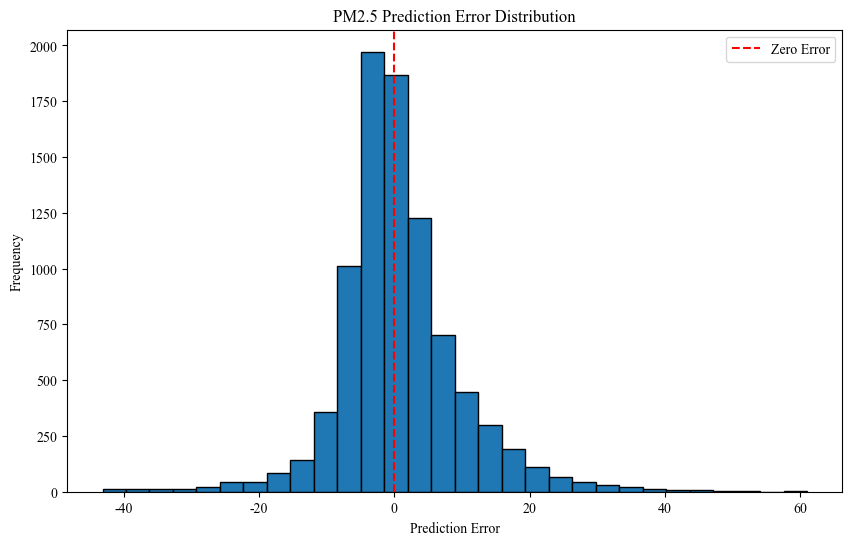

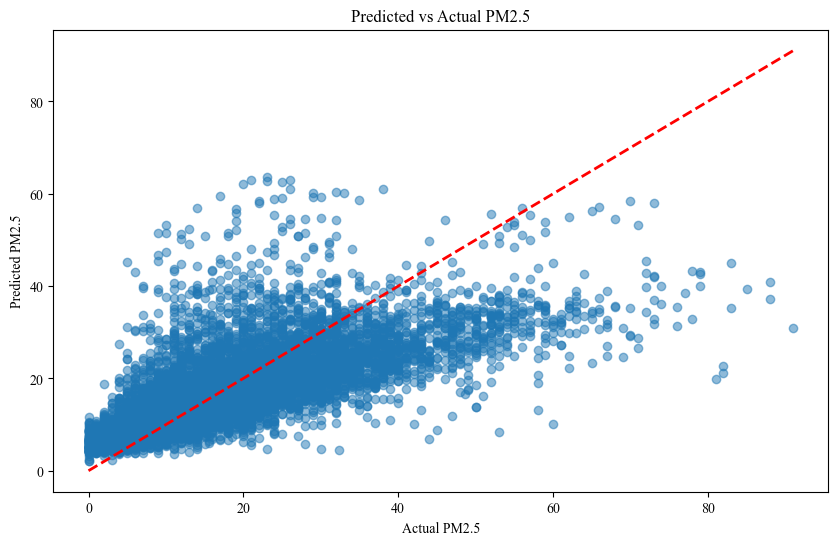

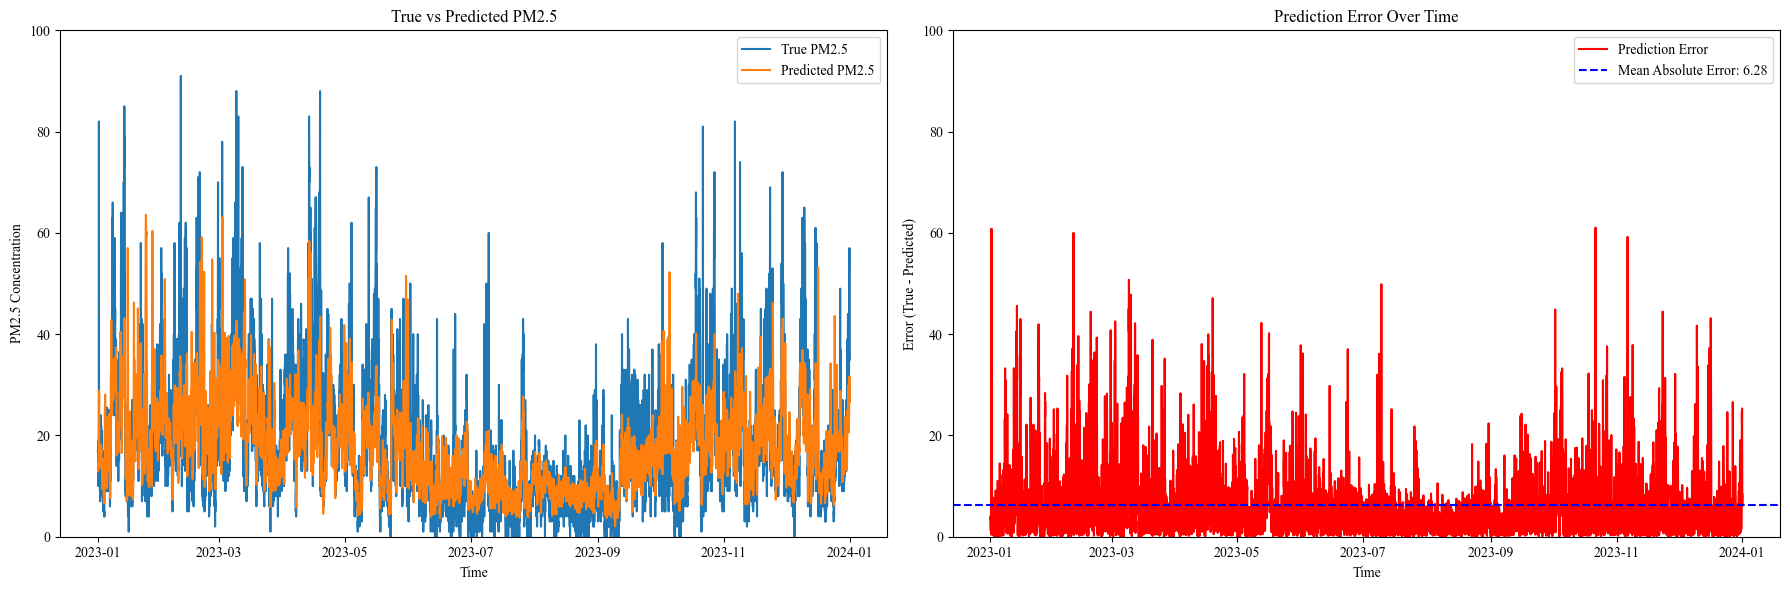

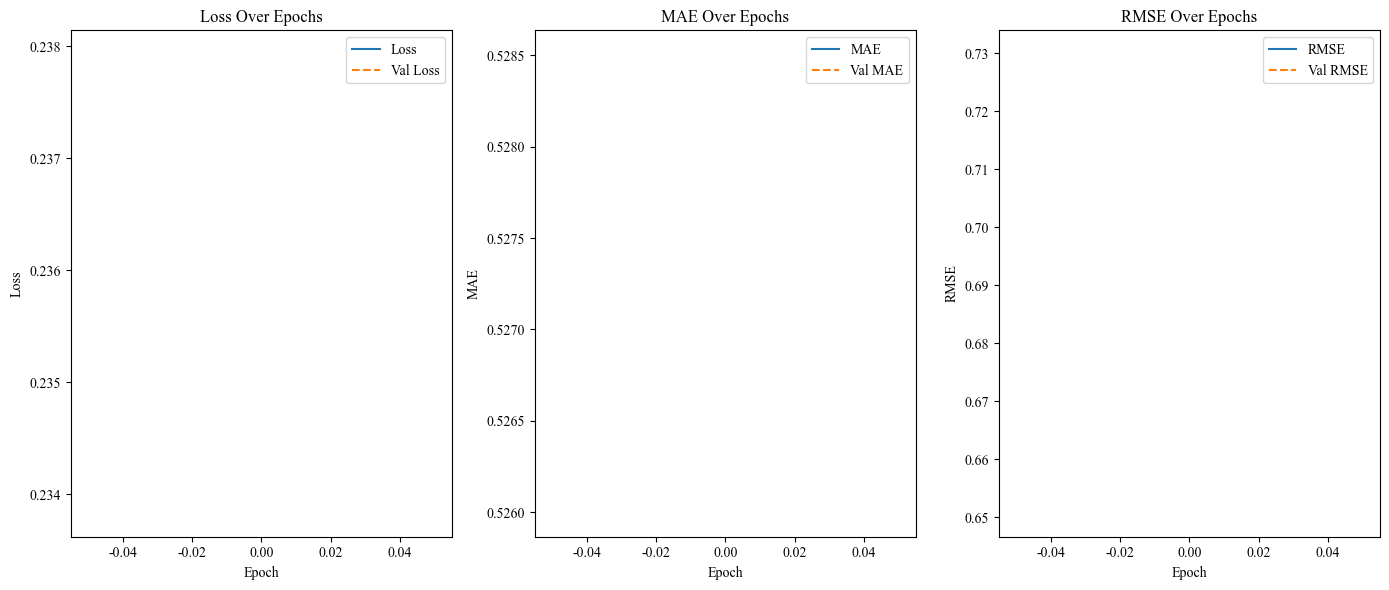

,時間,Pred_PM2.5,Latitude,Longitude
0,2023-01-01 04:00:00,13.572558,23.925175,120.409653
1,2023-01-01 05:00:00,13.037994,23.925175,120.409653
2,2023-01-01 06:00:00,12.888983,23.925175,120.409653
3,2023-01-01 07:00:00,13.210855,23.925175,120.409653
4,2023-01-01 08:00:00,14.253550,23.925175,120.409653
...,...,...,...,...
8751,2023-12-31 19:00:00,31.670206,23.925175,120.409653
8752,2023-12-31 20:00:00,31.396521,23.925175,120.409653
8753,2023-12-31 21:00:00,30.158672,23.925175,120.409653
8754,2023-12-31 22:00:00,28.905323,23.925175,120.409653


In [16]:
all_results = []

# Loop through all station datasets and process each
for station_df, station_name in zip(station_dfs, station_names):
    station_results, ERROR_df = process_and_predict(station_df, FEATURES, TARGET, TIME_STEPS, station_name)
    all_results.append(station_results)

# Optionally concatenate all results into a single DataFrame
all_results_df = pd.concat(all_results, ignore_index=False)
all_results_df

In [17]:
def print_significant_errors(error_df, threshold=10):
    error_df_reset = error_df.reset_index()
    
    # Find dates with absolute error greater than the threshold
    significant_errors = error_df_reset[error_df_reset['Absolute_Error'] > threshold]
    
    if not significant_errors.empty:
        print("Dates with Absolute Error greater than {}: ".format(threshold))
        print(significant_errors[['時間', 'True_PM2.5', 'Predicted_PM2.5', 'Absolute_Error']])
        
        # Save significant errors to a CSV file
        significant_errors[['時間', 'True_PM2.5', 'Predicted_PM2.5', 'Absolute_Error']].to_csv(output_path, index=False)
        print("Significant errors saved to '{}'.".format(output_path))
    else:
        print("No significant errors found (greater than {}).".format(threshold))

In [18]:
print_significant_errors(ERROR_df)

Dates with Absolute Error greater than 10: 
                      時間  True_PM2.5  Predicted_PM2.5  Absolute_Error
12   2023-01-01 16:00:00        82.0        21.170546       60.829454
14   2023-01-01 18:00:00        11.0        28.861307       17.861307
15   2023-01-01 19:00:00        14.0        28.290096       14.290096
84   2023-01-04 16:00:00        17.0        28.064802       11.064802
108  2023-01-05 16:00:00         9.0        23.477686       14.477686
...                  ...         ...              ...             ...
8748 2023-12-31 16:00:00        47.0        24.417912       22.582088
8749 2023-12-31 17:00:00        52.0        27.208033       24.791967
8750 2023-12-31 18:00:00        53.0        30.366653       22.633347
8751 2023-12-31 19:00:00        57.0        31.670206       25.329794
8752 2023-12-31 20:00:00        46.0        31.396521       14.603479

[1600 rows x 4 columns]
Significant errors saved to './Predict_Result/significant_errors.csv'.
